In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import cpu_count
import os
from random import shuffle

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_lightning.loggers.neptune import NeptuneLogger
import ray
import seaborn
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from nemo.data.dataloader import TrialAvgNeuralDataset
from nemo.model.layers import Identity
from nemo.model.analysis.feature_visualization import write_simple_cell_strfs
from nemo.model.analysis.metrics import cc_norm
from nemo.model.models import ElasticNet
from nemo.model.utils import tune_model

In [2]:
def get_preds(model, dl):
    for batch_num, batch in enumerate(dl):
        y = batch[1][-1]
        batch = ([x.cuda() for x in batch[0]], [y.cuda() for y in batch[1]])
        y_hat = best_model.predict_step(batch, batch_num)
        
        if batch_num == 0:
            preds = np.zeros([0, y.shape[1]])
            true = preds.copy()

        preds = np.concatenate((preds, y_hat.detach().cpu().numpy()), 0)
        true = np.concatenate((true, y.numpy()), 0)
        
    return preds, true

# Single Neuron Model

## Set Parameters

Dataset Parameters

In [3]:
n_frames = 9
stim_height = 40 
stim_width = 64
train_stim = ['natural_movie_three']
val_stim = ['natural_movie_two']
test_stim = ['natural_movie_one']

Hyper-parameter values to search over

In [4]:
alphas = ray.tune.uniform(0.0, 1.0)
lambdas = ray.tune.loguniform(1e-6, 1.0)
lrs = ray.tune.loguniform(1e-5, 1e-3)
batch_sizes = 256
loss_fns = torch.nn.PoissonNLLLoss(log_input = False)
input_norms = torch.nn.LayerNorm(
    n_frames * stim_height * stim_width, 
    elementwise_affine = False
)
act_norms = None
optims = torch.optim.Adam
act_fns = torch.nn.Sigmoid()
n_tune_samples = 20

Data Loader Parameters

In [5]:
n_workers = 10

Trainer and Model Args

In [6]:
n_gpu_tune = 0.33
max_steps = 4000
n_cpu_tune = 4
patience = 4
tol = 1e-4
model_name = 'single_neuron'

## Initialize the Dataset

In [7]:
dset = TrialAvgNeuralDataset(
    data_dir = '../../data/AIBO/VISp/L4/Exc/ExtractedData',
    stimuli = train_stim + val_stim + test_stim,
    stim_height = stim_height,
    stim_width = stim_width,
    n_frames = n_frames,
    col_transform = lambda x: x.abs().divide(x.abs().max())
)

INFO -- 04/10/2021 03:08:38 PM -- Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/home/mteti/NEMO/nemo/model/analysis/metrics.py:164: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(SP / true.groupby('stimulus').var())
INFO -- 04/10/2021 03:09:52 PM -- DATASET INITIALIZED
INFO -- 04/10/2021 03:09:52 PM --    - NEURAL DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/NeuralData
INFO -- 04/10/2021 03:09:52 PM --    - STIMULI DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/Stimuli
INFO -- 04/10/2021 03:09:52 PM --    - STIMULI: ['natural_movie_three', 'natural_movie_two', 'natural_movie_one']
INFO -- 04/10/2021 03:09:52 PM --    - CRE LINES: None
INFO -- 04/10/2021 03:09:52 PM --    - NUM. CELLS: 5353
INFO -- 04/10/2021 03:09:52 PM --    - NUM. ANIMALS: 45
INFO -- 04/10/2021 03:09:52 PM --    - NUM. STIMULUS FRAMES: 5400


In [8]:
dset.data

,stimulus,frame,517397343_511498742,517397347_511498742,517397357_511498742,517397441_511498742,517397464_511498742,517397474_511498742,517397528_511498742,517397564_511498742,...,738948440_712178509,738948535_712178509,738948566_712178509,738948605_712178509,738948646_712178509,738948685_712178509,738948725_712178509,738948770_712178509,738948842_712178509,738948929_712178509
0,natural_movie_one,0.0,0.010422,0.004444,0.009537,0.078491,0.001704,0.008606,0.284424,0.013405,...,0.014351,0.015656,0.081177,0.001443,0.008263,0.046112,0.015480,0.037415,0.025589,0.047089
1,natural_movie_one,1.0,0.074036,0.022018,0.017807,0.015762,0.039795,0.007526,0.286865,0.003563,...,0.050629,0.043823,0.043304,0.012413,0.050842,0.016510,0.017593,0.004734,0.032410,0.031738
2,natural_movie_one,2.0,0.012741,0.055664,0.017517,0.015282,0.021881,0.037933,0.258301,0.006096,...,0.030197,0.019760,0.093323,0.033539,0.017731,0.033752,0.031464,0.007153,0.021713,0.028183
3,natural_movie_one,3.0,0.067871,0.002438,0.011116,0.082336,0.023987,0.045044,0.220703,0.006897,...,0.043152,0.094299,0.084961,0.061462,0.020569,0.044830,0.004925,0.004425,0.002554,0.040924
4,natural_movie_one,4.0,0.043518,0.051575,0.027542,0.043091,0.001768,0.002468,0.167725,0.012466,...,0.032349,0.028671,0.020996,0.048401,0.024414,0.017715,0.022720,0.011963,0.023315,0.046600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,natural_movie_two,895.0,0.000597,0.154907,0.015579,0.036316,0.068665,0.066162,0.023529,0.000123,...,0.036194,0.031677,0.057556,0.123840,0.089111,0.105591,0.050781,0.058990,0.153442,0.002123
5396,natural_movie_two,896.0,0.026871,0.136719,0.001554,0.013878,0.034363,0.009903,0.017181,0.007790,...,0.002495,0.089966,0.018768,0.134521,0.007736,0.077942,0.040588,0.009178,0.085693,0.011238
5397,natural_movie_two,897.0,0.083130,0.156494,0.009636,0.070190,0.034698,0.009804,0.001986,0.001776,...,0.003206,0.046173,0.173950,0.059906,0.103271,0.107483,0.034271,0.081543,0.058655,0.130127
5398,natural_movie_two,898.0,0.035095,0.110413,0.017670,0.001190,0.075928,0.058716,0.005875,0.004822,...,0.048157,0.023407,0.006702,0.026566,0.003452,0.171631,0.057159,0.035065,0.059082,0.020096


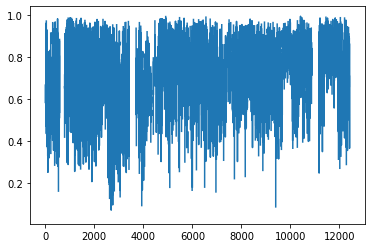

In [9]:
plt.plot(dset.cc_max[dset.cc_max.index == test_stim[0]].to_numpy()[0])

Text(96.0, 0.5, 'Neuron')

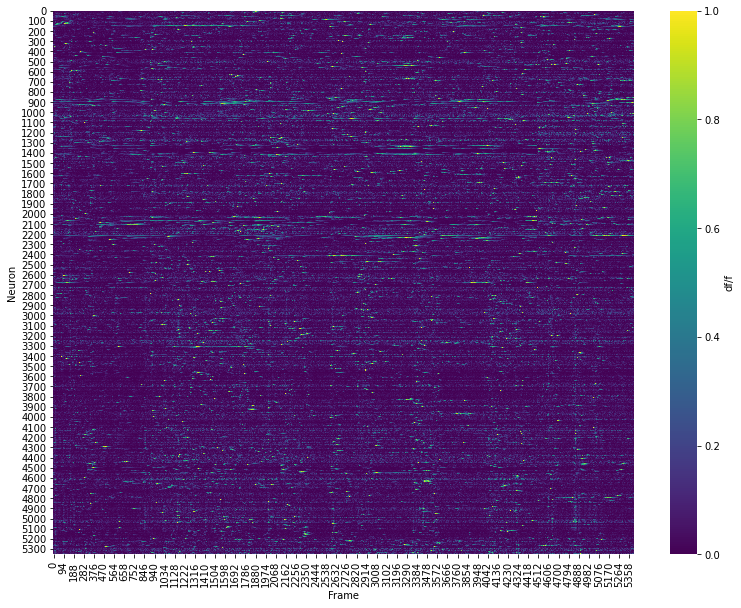

In [10]:
fig = plt.figure(figsize = (13, 10))
seaborn.heatmap(
    data = dset.data.set_index(['stimulus', 'frame']).to_numpy().transpose(),
    cmap = 'viridis',
    vmin = 0.0,
    cbar_kws = {'label': 'df/f'}
)
plt.xlabel('Frame')
plt.ylabel('Neuron')

In [11]:
train_inds = dset.data.index[dset.data.stimulus.isin(train_stim)].to_list()
val_inds = dset.data.index[dset.data.stimulus.isin(val_stim)].to_list()
test_inds = dset.data.index[dset.data.stimulus.isin(test_stim)].to_list()
print(
    len(train_inds), 
    len(val_inds), 
    len(test_inds), 
    len(set(train_inds) & set(test_inds)), 
    len(set(val_inds) & set(test_inds)),
    len(set(train_inds) & set(val_inds))
)

3600 900 900 0


## Run Hyper-Parameter Search

In [12]:
ray.init(include_dashboard = False)

{'node_ip_address': '192.168.1.15',
 'raylet_ip_address': '192.168.1.15',
 'redis_address': '192.168.1.15:6379',
 'object_store_address': '/tmp/ray/session_2021-04-10_15-10-08_817410_21238/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-10_15-10-08_817410_21238/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-04-10_15-10-08_817410_21238',
 'metrics_export_port': 45771,
 'node_id': '620df62470f675c35cda1e20c3611f25027787a64b73532b17467d67'}

In [13]:
config = {
    'lr': lrs,
    'alpha': alphas,
    'lambd': lambdas,
    'act_fn': act_fns,
    'loss_fn': loss_fns,
    'optim': optims,
    'input_norm_fn': input_norms,
    'norm_fn': act_norms,
    'batch_size': batch_sizes,
    'n_neurons': 1,
    'in_h': stim_height,
    'in_w': stim_width,
    'n_frames': n_frames,
    'patience': patience,
    'tol': tol
}

In [14]:
cell_inds = list(range(len(dset.cell_ids)))
shuffle(cell_inds)
print(cell_inds[:10])

[565, 3898, 522, 250, 504, 4714, 4162, 4375, 4123, 5114]


In [ ]:
for i, (cell_id, cont_id) in enumerate(zip([dset.cell_ids[i] for i in cell_inds], [dset.cont_ids[i] for i in cell_inds])):
    results_dir = os.path.join('results', model_name, cell_id + '_' + cont_id)
    if os.path.isdir(results_dir): continue
    
    # get a new dataset with just that cell ID
    dset = TrialAvgNeuralDataset(
        data_dir = '../../data/AIBO/VISp/L4/Exc/ExtractedData',
        stimuli = train_stim + val_stim + test_stim,
        stim_height = stim_height,
        stim_width = stim_width,
        n_frames = n_frames,
        col_transform = lambda x: x.abs().divide(x.abs().max()),
        cell_ids = [cell_id]
    )

    ################ perform hyper-parameter tuning ###################
    analysis = ray.tune.run(
        ray.tune.with_parameters(
            tune_model,
            ptl_model = ElasticNet,
            dset = dset,
            train_inds = train_inds,
            val_inds = val_inds,
            n_workers = n_workers,
            tune_metrics = {'loss': 'val_loss'},
            mode = 'tune',
            gpus = int(np.ceil(n_gpu_tune)),
            max_steps = max_steps,
            check_val_every_n_epoch = 1,
            progress_bar_refresh_rate = 0,
            weights_summary = None
        ),
        config = config,
        num_samples = n_tune_samples,
        resources_per_trial = {'cpu': n_cpu_tune, 'gpu': n_gpu_tune},
        verbose = 1, 
        metric = 'loss',
        mode = 'min',
        local_dir = results_dir,
        checkpoint_freq = 0
    )
    # write hp tuning results dataframe
    analysis.results_df.to_csv(os.path.join(results_dir, 'results.txt'))
    
    
    ############## train a model on best config found ###############
    trainer = tune_model(
        config = analysis.best_config,
        ptl_model = ElasticNet,
        dset = dset,
        train_inds = train_inds + val_inds,
        n_workers = cpu_count() - 4,
        val_inds = train_inds + val_inds,
        mode = 'train',
        gpus = int(np.ceil(n_gpu_tune)),
        max_steps = max_steps,
        check_val_every_n_epoch = 1,
        progress_bar_refresh_rate = 50,
        default_root_dir = os.path.join(results_dir, 'checkpoints'),
        log_every_n_steps = 5,
        logger = NeptuneLogger(
            api_key = os.environ['NEPTUNE_API_TOKEN'],
            project_name = 'mteti/neural-encoding-elasticnet',
            experiment_name = model_name + '_' + cell_id + '_' + cont_id,
            params = {
                k: v.real if k in ['alpha', 'lr', 'lambd'] else v 
                for k, v in analysis.best_config.items()
            }
        )
    )
    
    # get trained model
    best_model = trainer.get_model()
    
    
    ################# test model ##################
    test_dl = DataLoader(
        dset,
        batch_size = analysis.best_config['batch_size'],
        num_workers = n_workers,
        sampler = SequentialSampler(test_inds),
        drop_last = False
    )
    trainer.test(best_model, test_dl)
    
    
    ################# predict on test samples ######################
    preds, true = get_preds(best_model, test_dl)
    pred_df = pd.DataFrame(
        {
            'y': true[:, 0],
            'y_hat': preds[:, 0]
        }
    )
    pred_df.to_csv(os.path.join(results_dir, 'preds.txt'))
    
    
    ###################### write STRFs ##############################
    best_weights = best_model.strf.weight.detach().cpu().numpy()
    best_weights = best_weights.reshape([-1, n_frames, stim_height, stim_width])
    best_weights = [best_weights[:, frame_num, ...][:, None, None, None] for frame_num in range(n_frames)]
    write_simple_cell_strfs(best_weights, os.path.join(results_dir, 'weights'))